# A. Business Understanding

Proyek Predictive Analytics: Prediksi Harga IHSG (^JKSE)
Mengikuti Metode CRISP-DM 6 Fase

Problem Steatment:
- Volatilitas IHSG (^JKSE) yang tinggi membutuhkan perbandingan akurasi dengan model lain.
- Belum banyak yang membahas studi komparatif yang fokus pada penerapan model deep learning seperti LSTM, CNN, dan GRU secara individual untuk memprediksi harga penutupan IHSG.

Goals:
- Menghasilkan model prediksi IHSG yang mampu mengurangi nilai error (MSE, RMSE MAE, MAPE, dan R2) dengan membandingkan model LSTM, CNN, dan GRU secara individual.
- Memberikan insight kuantitatif dan visual terhadap kemampuan masing-masing model dalam menangkap pola harga historis IHSG dan memprediksi harga di masa depan.

Solution statements:
- Mengimplementasikan dan melatih tiga model deep learning secara terpisah: LSTM, CNN, dan GRU menggunakan dataset historis harga penutupan IHSG (^JKSE).
- Mengukur performa setiap model menggunakan metrik kuantitatif yang objektif seperti Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean absolute percentage error (MAPE), dan R-Squared (R2).

Tambahan - Hardware:
- Processor: Ryzen 7 5700X
- Ram: 32GB DDR4
- GPU: RTX 3060 12GB GDDR6

Tambahan - Software:
- OS: Windows 11 Home 64bit
- Notebook: Google Colab (CPU)
- Docker untuk Local Runtime GPU
- Untuk instalasi API, Framework, ataupun Library dapat dilakukan melalui file requirements.txt

## 1. Instalasi Library yang dibutuhkan

In [1]:
!pip install yfinance==0.2.54

## 2. Import Library yang akan digunakan

In [2]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# B. Data Understanding

## 1. Mengambil data historis maksimal dari Yahoo Finance (Data Loading)

In [3]:
def fetch_jkse_historical():
    """
    Mengambil seluruh data historis IHSG dari awal hingga hari ini.
    """
    ticker = yf.Ticker("^JKSE")

    # Ambil data maksimum yang tersedia (dari awal hingga hari ini)
    df = ticker.history(period="max", actions=False)

    # Reset index dan ubah format tanggal
    df = df.reset_index()
    df = df.rename(columns={'Date': 'date'})

    # Konversi tipe data datetime ke string (opsional)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    return df

if __name__ == "__main__":
    try:
        # Ambil data historis
        historical_data = fetch_jkse_historical()

        # Simpan ke CSV
        historical_data.to_csv("jkse_historical.csv", index=False)
        print(f"Data berhasil disimpan! Jumlah baris: {len(historical_data)}")

    except Exception as e:
        print(f"Terjadi error: {str(e)}")

Data berhasil disimpan! Jumlah baris: 8534


## 2. EDA - Deskripsi Variabel

Memuat dataset dari directory /Data :

In [4]:
maindf=pd.read_csv('/content/jkse_historical.csv')

Menampilkan 5 data terbaru dan Terlama :

In [5]:
maindf

,date,Open,High,Low,Close,Volume
0,1990-04-06,641.244019,641.244019,641.244019,641.244019,0
1,1990-04-09,633.457336,633.457336,633.457336,633.457336,0
2,1990-04-10,632.061340,632.061340,632.061340,632.061340,0
3,1990-04-11,634.668274,634.668274,634.668274,634.668274,0
4,1990-04-12,639.589111,639.589111,639.589111,639.589111,0
...,...,...,...,...,...,...
8529,2025-04-11,6195.567871,6298.777832,6148.775879,6262.226074,117642700
8530,2025-04-14,6225.336914,6404.069824,6225.336914,6368.517090,149701700
8531,2025-04-15,6444.341797,6497.532227,6395.926758,6441.683105,147079600
8532,2025-04-16,6461.273926,6469.597168,6373.790039,6400.054199,142022700


Menampilkan jumlah data dan feature pada dataset:

In [6]:
maindf.shape

(8534, 6)

Menampilkan informasi mengenai tipe data pada dataset:

In [7]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8534 entries, 0 to 8533
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8534 non-null   object 
 1   Open    8534 non-null   float64
 2   High    8534 non-null   float64
 3   Low     8534 non-null   float64
 4   Close   8534 non-null   float64
 5   Volume  8534 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 400.2+ KB


Menampilkan informasi mengenai Statistik Deskriptif data pada dataset:

In [8]:
maindf.describe()

,Open,High,Low,Close,Volume
count,8534.000000,8534.000000,8534.000000,8534.000000,8.534000e+03
mean,2813.859920,2829.446948,2796.119008,2813.659283,5.117802e+07
std,2474.426059,2486.404789,2460.576170,2473.347001,2.048168e+08
min,223.240311,223.240311,223.240311,223.240311,0.000000e+00
25%,504.536086,507.745232,500.253306,504.472839,2.722250e+06
50%,1780.532127,1792.123208,1769.664655,1783.895569,2.083670e+07
75%,5136.955079,5164.180054,5112.891235,5140.251587,5.376012e+07
max,7904.395020,7910.556152,7853.353027,7905.390137,9.788202e+09


## 3. EDA - Menangani Missing Value dan Outliers

Memeriksa dan menghapus Missing Values, jika terdapat Missing Values jumlah data akan berubah

In [9]:
def handle_missing_values(df):
    print("\n=== Penanganan Missing Values ===")

    # Cek jumlah missing values
    print("\nMissing Values Sebelum Penanganan:")
    print(df.isnull().sum())

    # Handle missing values
    if df.isnull().sum().any():
        # Untuk data time series, gunakan interpolasi (https://medium.com/@aseafaldean/time-series-data-interpolation-e4296664b86)
        df_clean = df.interpolate(method='linear')
        print("\nMissing values diatasi dengan interpolasi linear")

        #Jika masih ada missing value setelah interpolasi
        if df_clean.isnull().sum().any():
          df_clean = df_clean.ffill().bfill()
          print("\nSisa Missing values diatasi dengan forward-fill dan back-fill")
    else:
        df_clean = df.copy()
        print("\nTidak ada missing values")

    # Verifikasi setelah penanganan
    print("\nMissing Values Setelah Penanganan:")
    print(df_clean.isnull().sum())

    return df_clean

# Contoh penggunaan
maindf_cleaned = handle_missing_values(maindf)


=== Penanganan Missing Values ===

Missing Values Sebelum Penanganan:
date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Tidak ada missing values

Missing Values Setelah Penanganan:
date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


Tampilkan data setelah penanganan missing values:

In [10]:
maindf_cleaned

,date,Open,High,Low,Close,Volume
0,1990-04-06,641.244019,641.244019,641.244019,641.244019,0
1,1990-04-09,633.457336,633.457336,633.457336,633.457336,0
2,1990-04-10,632.061340,632.061340,632.061340,632.061340,0
3,1990-04-11,634.668274,634.668274,634.668274,634.668274,0
4,1990-04-12,639.589111,639.589111,639.589111,639.589111,0
...,...,...,...,...,...,...
8529,2025-04-11,6195.567871,6298.777832,6148.775879,6262.226074,117642700
8530,2025-04-14,6225.336914,6404.069824,6225.336914,6368.517090,149701700
8531,2025-04-15,6444.341797,6497.532227,6395.926758,6441.683105,147079600
8532,2025-04-16,6461.273926,6469.597168,6373.790039,6400.054199,142022700


Melakukan proses IQR untuk mengatasi outlier

In [11]:
def handle_outliers(df, column):
    print(f"\n=== Penanganan Outliers pada kolom '{column}' ===")

    # Metode IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Jumlah outliers: {len(outliers)}")

    # Winsorizing (Batas atas/bawah diganti dengan batas IQR) https://www.stat.cmu.edu/~hseltman/309/Book/Book.pdf halaman 70
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    print("Outliers ditangani dengan Winsorizing")

    return df

# Contoh penggunaan untuk beberapa kolom (sesuaikan dengan kolom yang ingin diproses)
columns_to_check = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in columns_to_check:
    maindf_cleaned = handle_outliers(maindf_cleaned, col)


=== Penanganan Outliers pada kolom 'Open' ===
Jumlah outliers: 0
Outliers ditangani dengan Winsorizing

=== Penanganan Outliers pada kolom 'High' ===
Jumlah outliers: 0
Outliers ditangani dengan Winsorizing

=== Penanganan Outliers pada kolom 'Low' ===
Jumlah outliers: 0
Outliers ditangani dengan Winsorizing

=== Penanganan Outliers pada kolom 'Close' ===
Jumlah outliers: 0
Outliers ditangani dengan Winsorizing

=== Penanganan Outliers pada kolom 'Volume' ===
Jumlah outliers: 1022
Outliers ditangani dengan Winsorizing


Tampilkan data setelah penanganan outlier:

In [12]:
maindf_cleaned

,date,Open,High,Low,Close,Volume
0,1990-04-06,641.244019,641.244019,641.244019,641.244019,0.0
1,1990-04-09,633.457336,633.457336,633.457336,633.457336,0.0
2,1990-04-10,632.061340,632.061340,632.061340,632.061340,0.0
3,1990-04-11,634.668274,634.668274,634.668274,634.668274,0.0
4,1990-04-12,639.589111,639.589111,639.589111,639.589111,0.0
...,...,...,...,...,...,...
8529,2025-04-11,6195.567871,6298.777832,6148.775879,6262.226074,117642700.0
8530,2025-04-14,6225.336914,6404.069824,6225.336914,6368.517090,130316937.5
8531,2025-04-15,6444.341797,6497.532227,6395.926758,6441.683105,130316937.5
8532,2025-04-16,6461.273926,6469.597168,6373.790039,6400.054199,130316937.5


Visualisasi data 'Open' setelah penanganan outliers

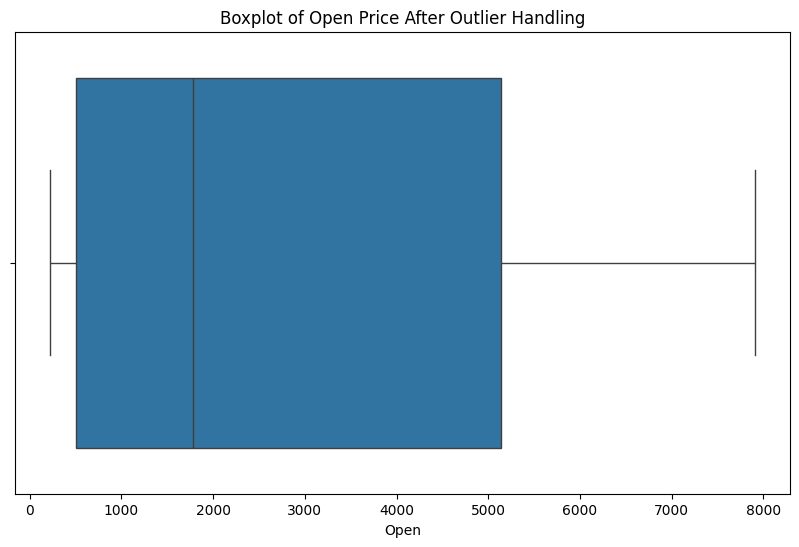

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['Open'])
plt.title('Boxplot of Open Price After Outlier Handling')
plt.show()

Visualisasi data 'Close' setelah penanganan outliers

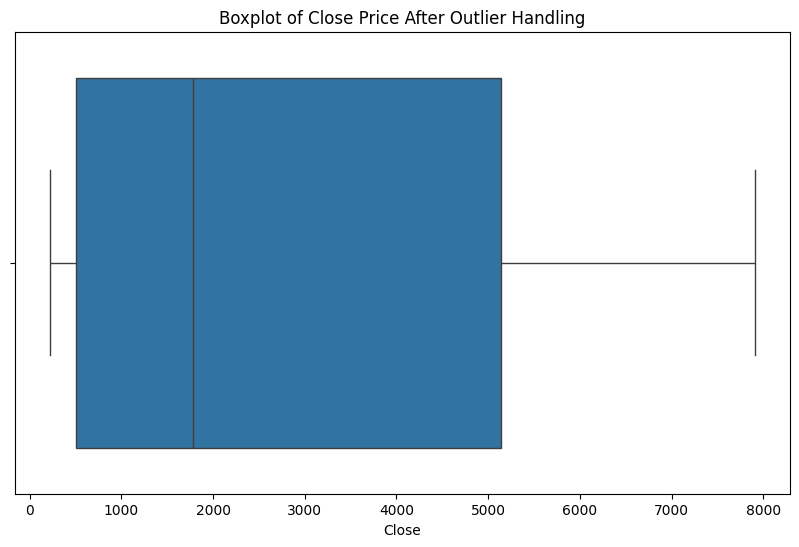

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['Close'])
plt.title('Boxplot of Close Price After Outlier Handling')
plt.show()

Visualisasi data 'High' setelah penanganan outliers

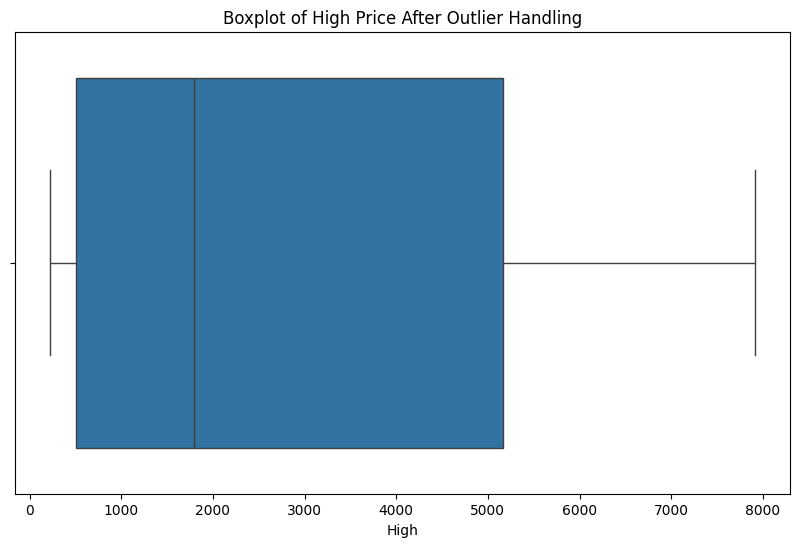

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['High'])
plt.title('Boxplot of High Price After Outlier Handling')
plt.show()

Visualisasi data 'Low' setelah penanganan outliers

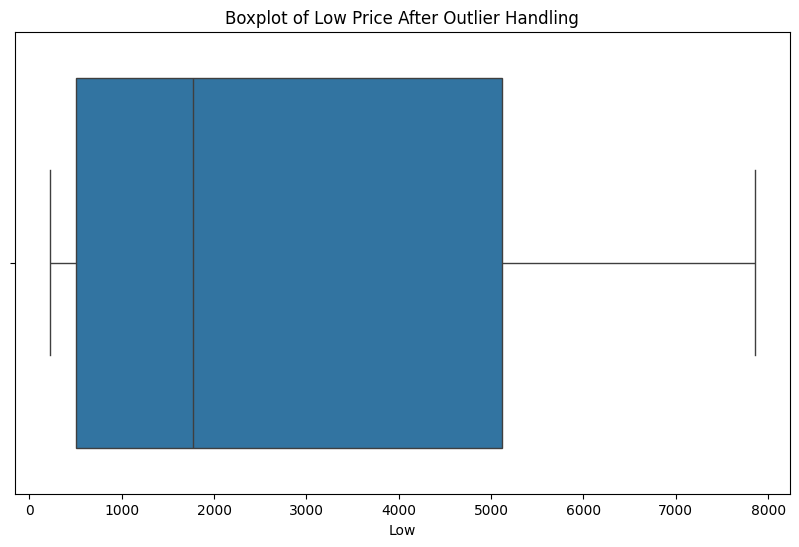

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['Low'])
plt.title('Boxplot of Low Price After Outlier Handling')
plt.show()

Visualisasi data 'Volume' setelah penanganan outliers

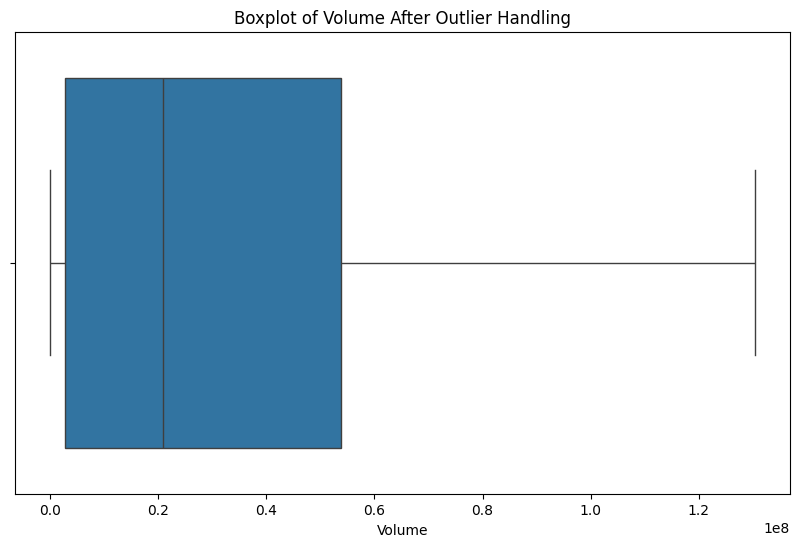

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=maindf_cleaned['Volume'])
plt.title('Boxplot of Volume After Outlier Handling')
plt.show()

Visualisasi data 'Open', 'Close', 'High', 'Low', dan 'Volume' setelah penanganan outliers dalam boxplot

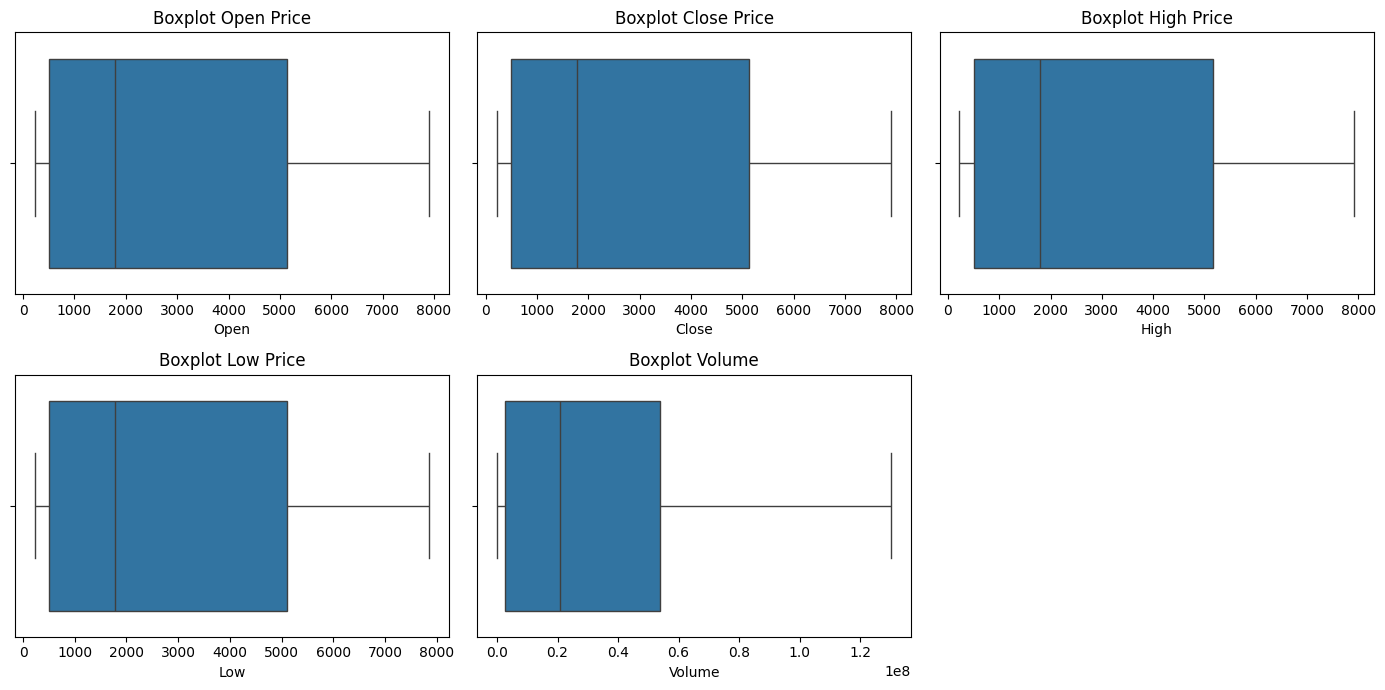

In [18]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 3, 1)
sns.boxplot(x=maindf_cleaned['Open'])
plt.title('Boxplot Open Price')

plt.subplot(2, 3, 2)
sns.boxplot(x=maindf_cleaned['Close'])
plt.title('Boxplot Close Price')

plt.subplot(2, 3, 3)
sns.boxplot(x=maindf_cleaned['High'])
plt.title('Boxplot High Price')

plt.subplot(2, 3, 4)
sns.boxplot(x=maindf_cleaned['Low'])
plt.title('Boxplot Low Price')

plt.subplot(2, 3, 5)
sns.boxplot(x=maindf_cleaned['Volume'])
plt.title('Boxplot Volume')

plt.tight_layout()
plt.show()

## 4. EDA - Univariate Analysis

Univariate Analysis - Histograms untuk seluruh feature

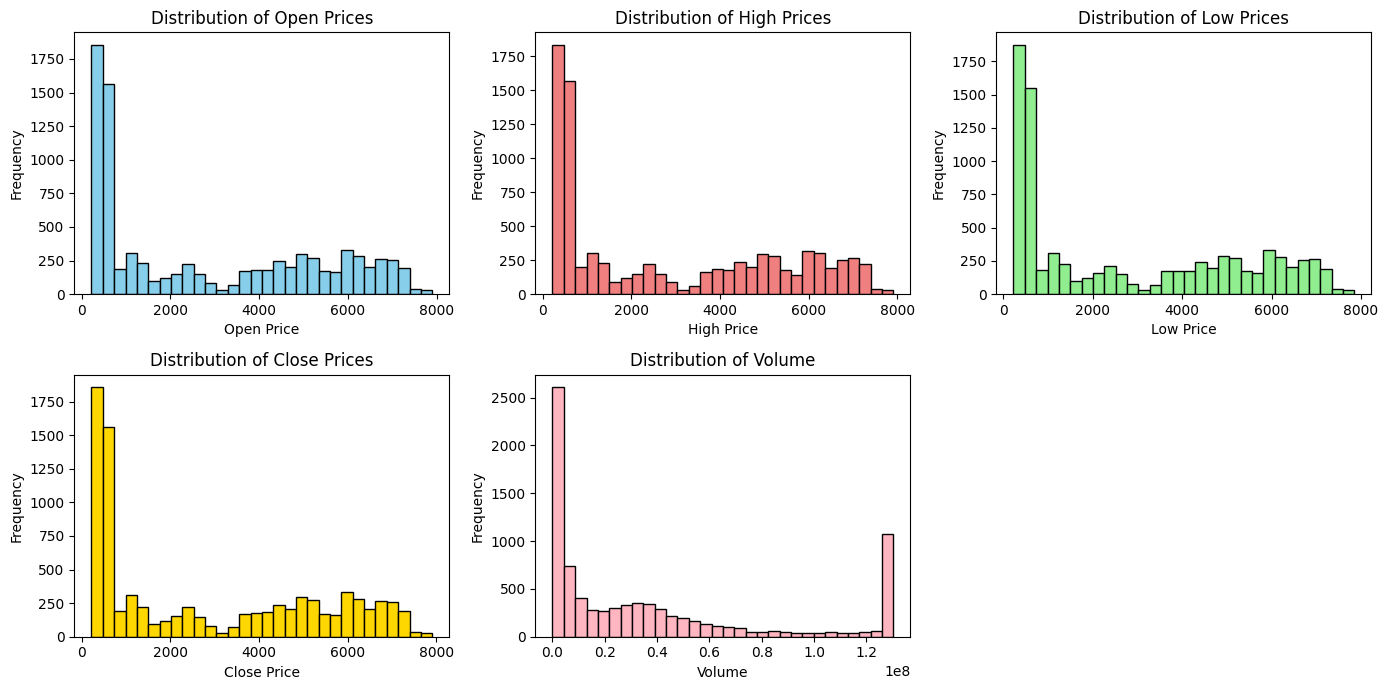

In [19]:
plt.figure(figsize=(14, 7))

# Histogram 'Open'
plt.subplot(2, 3, 1)
plt.hist(maindf_cleaned['Open'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Open Prices')
plt.xlabel('Open Price')
plt.ylabel('Frequency')

# Histogram 'High'
plt.subplot(2, 3, 2)
plt.hist(maindf_cleaned['High'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of High Prices')
plt.xlabel('High Price')
plt.ylabel('Frequency')

# Histogram 'Low'
plt.subplot(2, 3, 3)
plt.hist(maindf_cleaned['Low'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Low Prices')
plt.xlabel('Low Price')
plt.ylabel('Frequency')

# Histogram 'Close'
plt.subplot(2, 3, 4)
plt.hist(maindf_cleaned['Close'], bins=30, color='gold', edgecolor='black')
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')

# Histogram 'Volume'
plt.subplot(2, 3, 5)
plt.hist(maindf_cleaned['Volume'], bins=30, color='lightpink', edgecolor='black')
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Menampilkan Density Plots

<ipython-input-20-2d05a322e095>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(maindf_cleaned['Open'], shade=True, color='skyblue')
<ipython-input-20-2d05a322e095>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(maindf_cleaned['High'], shade=True, color='lightcoral')
<ipython-input-20-2d05a322e095>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(maindf_cleaned['Low'], shade=True, color='lightgreen')
<ipython-input-20-2d05a322e095>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(maindf_cleaned

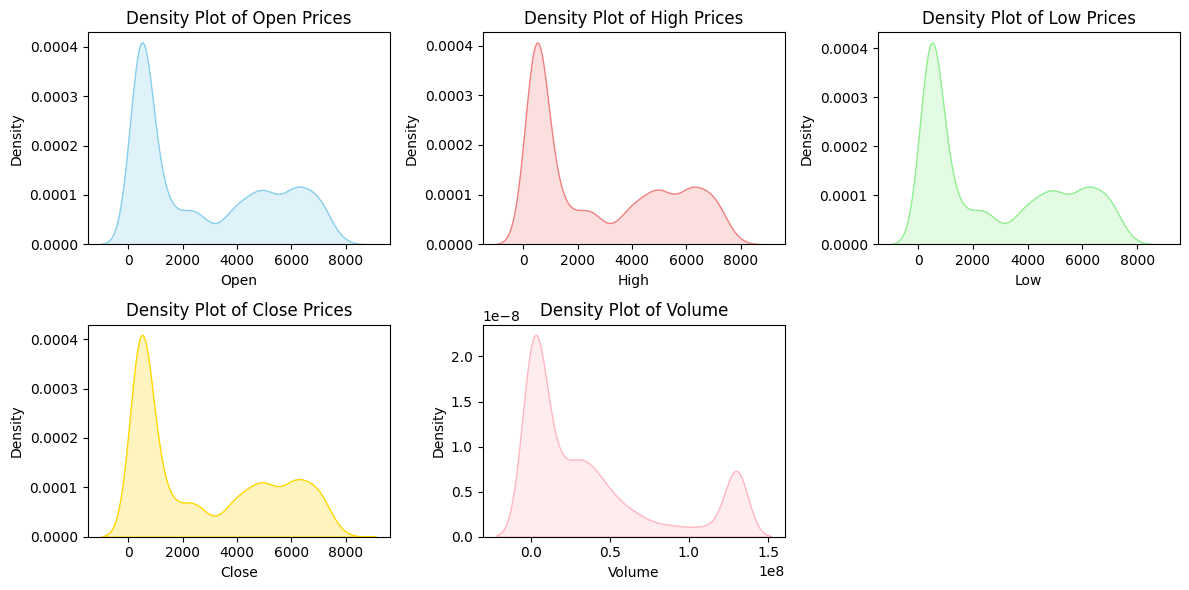

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
sns.kdeplot(maindf_cleaned['Open'], shade=True, color='skyblue')
plt.title('Density Plot of Open Prices')

plt.subplot(2, 3, 2)
sns.kdeplot(maindf_cleaned['High'], shade=True, color='lightcoral')
plt.title('Density Plot of High Prices')

plt.subplot(2, 3, 3)
sns.kdeplot(maindf_cleaned['Low'], shade=True, color='lightgreen')
plt.title('Density Plot of Low Prices')

plt.subplot(2, 3, 4)
sns.kdeplot(maindf_cleaned['Close'], shade=True, color='gold')
plt.title('Density Plot of Close Prices')

plt.subplot(2, 3, 5)
sns.kdeplot(maindf_cleaned['Volume'], shade=True, color='lightpink')
plt.title('Density Plot of Volume')

plt.tight_layout()
plt.show()


Visualisasikan Close Price Time Series

<ipython-input-21-1c4d5c78b011>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = maindf_cleaned['Close'].resample('M').mean()


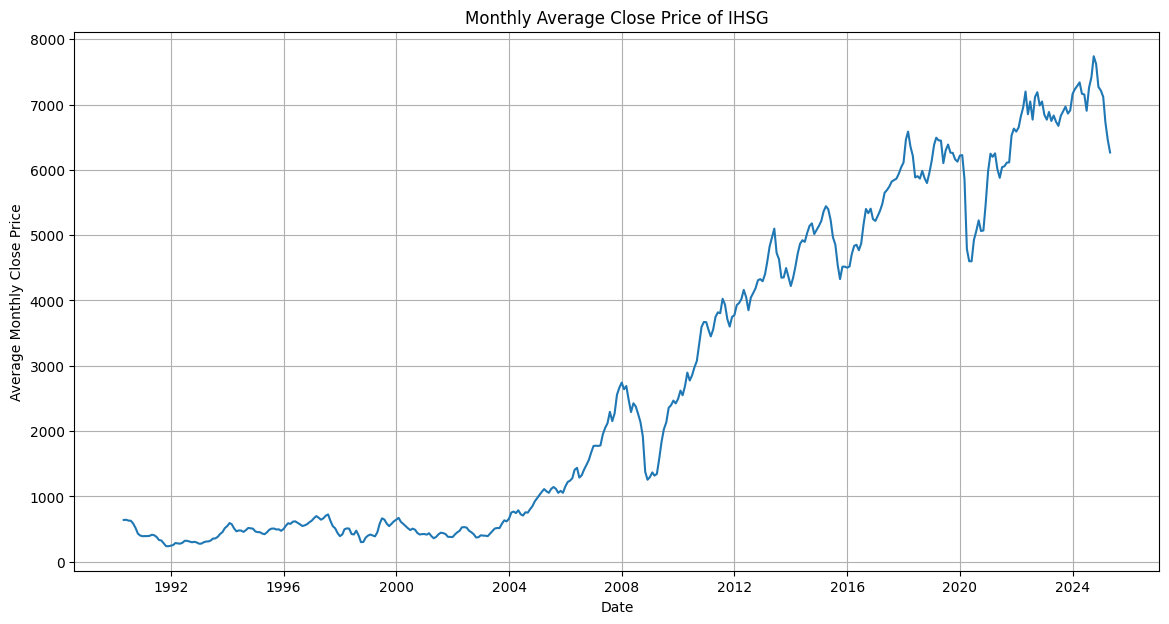

In [21]:
maindf_cleaned['date'] = pd.to_datetime(maindf_cleaned['date'])

# Set 'date' as index
maindf_cleaned = maindf_cleaned.set_index('date')

# Resample to monthly frequency and take the mean of 'Close' price
monthly_data = maindf_cleaned['Close'].resample('M').mean()

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data.values)
plt.xlabel("Date")
plt.ylabel("Average Monthly Close Price")
plt.title("Monthly Average Close Price of IHSG")
plt.grid(True)
plt.show()

Menampilkan Descriptive Statistics

In [22]:
maindf_cleaned.describe()

,Open,High,Low,Close,Volume
count,8534.000000,8534.000000,8534.000000,8534.000000,8.534000e+03
mean,2813.859920,2829.446948,2796.119008,2813.659283,3.794495e+07
std,2474.426059,2486.404789,2460.576170,2473.347001,4.419208e+07
min,223.240311,223.240311,223.240311,223.240311,0.000000e+00
25%,504.536086,507.745232,500.253306,504.472839,2.722250e+06
50%,1780.532127,1792.123208,1769.664655,1783.895569,2.083670e+07
75%,5136.955079,5164.180054,5112.891235,5140.251587,5.376012e+07
max,7904.395020,7910.556152,7853.353027,7905.390137,1.303169e+08


## 5. EDA - Multivariate Analysis

Melakukan Correlation Matrix

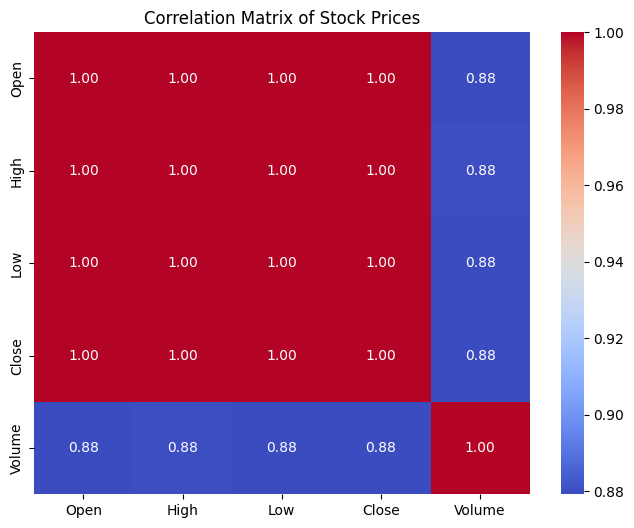

In [23]:
correlation_matrix = maindf_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Prices')
plt.show()

Menampilkan Scatter Plots

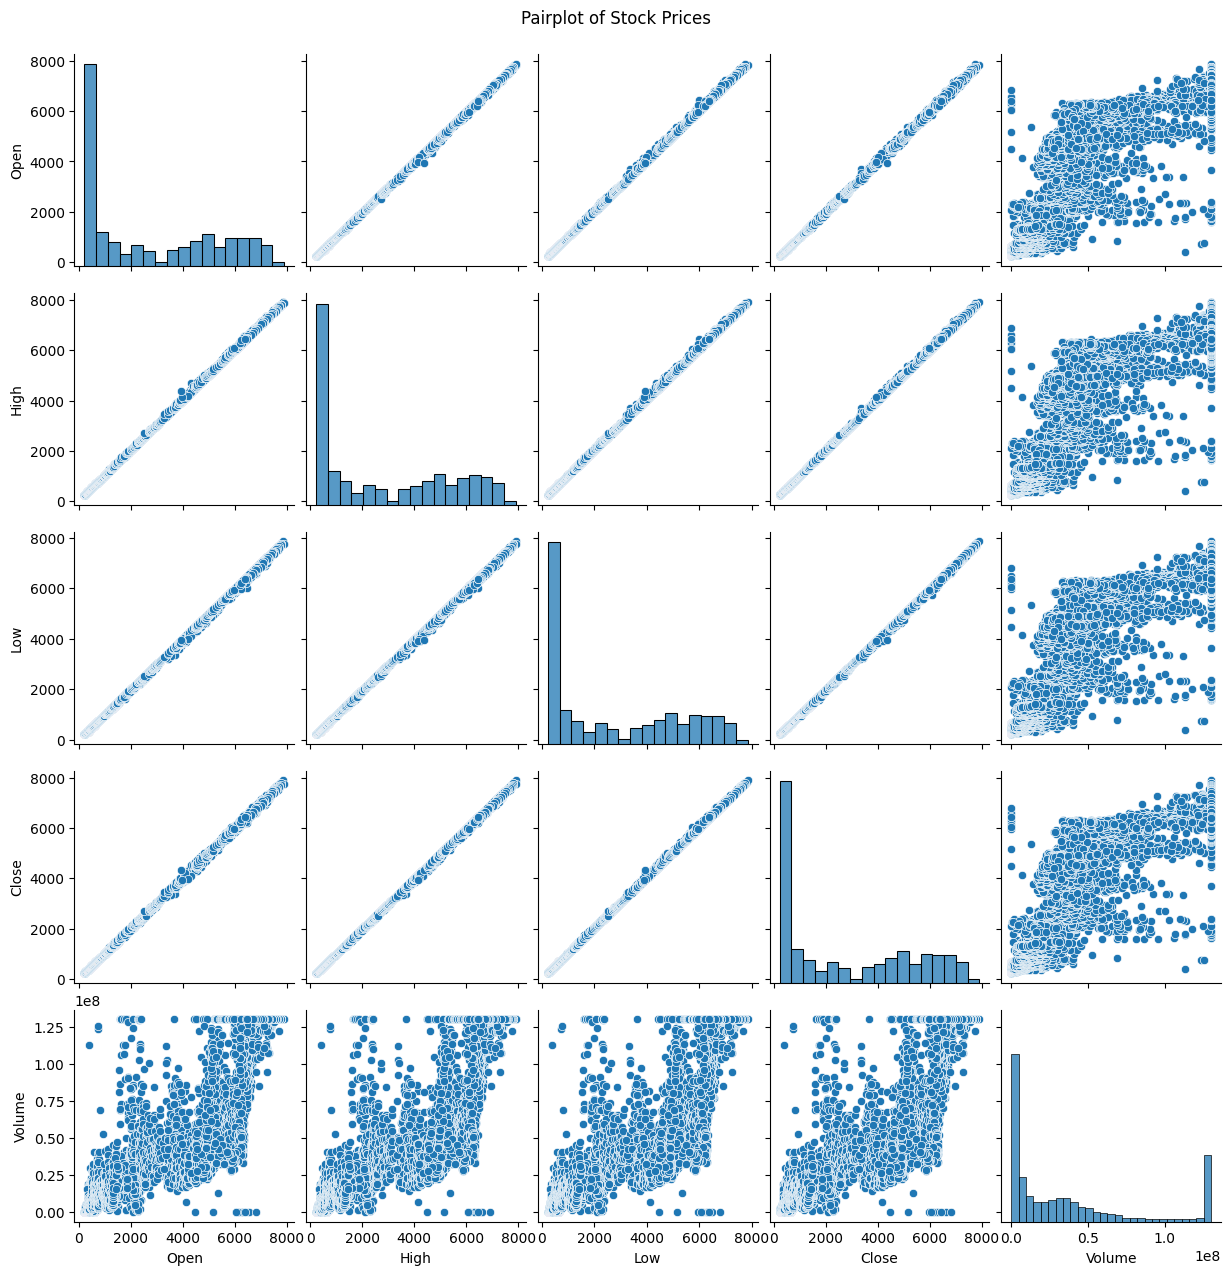

In [24]:
sns.pairplot(maindf_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.suptitle('Pairplot of Stock Prices', y=1.02)
plt.show()

Kesimpulan:
1. **Karena Volume tidak memiliki korelasi yang kuat dengan data lainnya maka tidak dipilih**. (DROP)
2. **Close yang akan dipilih karena dari keempat parameter lainnya hasilnya hampir sama**.

# C. Data Preparation

## 1. Encoding data dan pilih Feature Date dan Close

In [25]:
# Select 'date' and 'Close' columns
close_stock = maindf_cleaned.copy()
# Reset the index to get 'date' back as a column
selected_data = maindf_cleaned.reset_index()[['date', 'Close']]
selected_data

,date,Close
0,1990-04-06,641.244019
1,1990-04-09,633.457336
2,1990-04-10,632.061340
3,1990-04-11,634.668274
4,1990-04-12,639.589111
...,...,...
8529,2025-04-11,6262.226074
8530,2025-04-14,6368.517090
8531,2025-04-15,6441.683105
8532,2025-04-16,6400.054199


kemudian pilih 1000 data terbaru untuk data test dan data train

In [26]:
maindf_cleaned_split = maindf_cleaned[-1000:]
maindf_cleaned_split

,Open,High,Low,Close,Volume
date,,,,,
2021-02-23,6267.454102,6279.143066,6241.951172,6272.807129,126272800.0
2021-02-24,6283.794922,6294.140137,6223.648926,6251.054199,130316937.5
2021-02-25,6280.727051,6309.757812,6274.497070,6289.645996,130316937.5
2021-02-26,6246.316895,6302.394043,6184.517090,6241.795898,130316937.5
2021-03-01,6281.856934,6339.008789,6261.559082,6338.513184,130316937.5
...,...,...,...,...,...
2025-04-11,6195.567871,6298.777832,6148.775879,6262.226074,117642700.0
2025-04-14,6225.336914,6404.069824,6225.336914,6368.517090,130316937.5
2025-04-15,6444.341797,6497.532227,6395.926758,6441.683105,130316937.5


## 2. Bagi data kedalam data train (80%) dan data test (20%)

In [27]:
from sklearn.model_selection import train_test_split

# Select features (Close only)
selected_data = maindf_cleaned_split[['Close']]

# Split the data into training and testing sets (80:20)
train_data, test_data = train_test_split(selected_data, test_size=0.2, random_state=42, shuffle=False)  # Important: shuffle=False for time series data

# Now you have train_data and test_data
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (800, 1)
Testing data shape: (200, 1)


## 3. Standarisasi menggunakan metode Min-Max Scaler

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform both training and testing data
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# You can convert them back to dataframes if needed:
train_data_scaled = pd.DataFrame(train_data_scaled, columns=['Close'], index=train_data.index)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=['Close'], index=test_data.index)

print("Scaled Training data shape:", train_data_scaled.shape)
print("Scaled Testing data shape:", test_data_scaled.shape)


Scaled Training data shape: (800, 1)
Scaled Testing data shape: (200, 1)


Menampilkan data train yang sudah di normalisasi

In [29]:
train_data_scaled

,Close
date,
2021-02-23,0.306220
2021-02-24,0.293215
2021-02-25,0.316286
2021-02-26,0.287680
2021-03-01,0.345500
...,...
2024-06-11,0.654682
2024-06-12,0.651338
2024-06-13,0.640258


Menampilkan data test yang sudah di normalisasi

In [30]:
test_data_scaled

,Close
date,
2024-06-20,0.632939
2024-06-21,0.669201
2024-06-24,0.674694
2024-06-25,0.670831
2024-06-26,0.684544
...,...
2025-04-11,0.299894
2025-04-14,0.363437
2025-04-15,0.407178


## 4. Melakukan Reduksi dimensi dengan Principal Component Analysis (PCA)

In [31]:
'''
from sklearn.decomposition import PCA

# Inisialisasi PCA dengan jumlah komponen yang diinginkan (misalnya, 1 komponen)
pca = PCA(n_components=1)  # Sesuaikan jumlah komponen sesuai kebutuhan

# Fit PCA ke data training yang telah di-scaled
pca.fit(train_data_scaled)

# Transformasi data training dan testing menggunakan PCA
train_data_pca = pca.transform(train_data_scaled)
test_data_pca = pca.transform(test_data_scaled)

# Ubah kembali hasil PCA ke DataFrame (opsional)
train_data_pca = pd.DataFrame(data=train_data_pca, columns=['PC1'], index=train_data.index)
test_data_pca = pd.DataFrame(data=test_data_pca, columns=['PC1'], index=test_data.index)

print("PCA Training data shape:", train_data_pca.shape)
print("PCA Testing data shape:", test_data_pca.shape)
'''

'\nfrom sklearn.decomposition import PCA\n\n# Inisialisasi PCA dengan jumlah komponen yang diinginkan (misalnya, 1 komponen)\npca = PCA(n_components=1)  # Sesuaikan jumlah komponen sesuai kebutuhan\n\n# Fit PCA ke data training yang telah di-scaled\npca.fit(train_data_scaled)\n\n# Transformasi data training dan testing menggunakan PCA\ntrain_data_pca = pca.transform(train_data_scaled)\ntest_data_pca = pca.transform(test_data_scaled)\n\n# Ubah kembali hasil PCA ke DataFrame (opsional)\ntrain_data_pca = pd.DataFrame(data=train_data_pca, columns=[\'PC1\'], index=train_data.index)\ntest_data_pca = pd.DataFrame(data=test_data_pca, columns=[\'PC1\'], index=test_data.index)\n\nprint("PCA Training data shape:", train_data_pca.shape)\nprint("PCA Testing data shape:", test_data_pca.shape)\n'

### *PCA digunakan biasanya pada multivariate Time Series, sedangkan yang saya gunakan adalah Univariate Time Series

# D. Model Development

## 1. Long Short Term Memory (LSTM)

konversikan array nilai menjadi matriks kumpulan data

In [32]:
import numpy as np

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset['Close'][i:(i+time_step)].values
        dataX.append(a)
        # Use iloc to access data by position
        dataY.append(dataset['Close'].iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

Hasilnya diubah kedalam dataset data train dan data test

In [33]:
time_step = 10
X_train_lstm, y_train_lstm = create_dataset(train_data_scaled, time_step)
X_test_lstm, y_test_lstm = create_dataset(test_data_scaled, time_step)

print("X_train: ", X_train_lstm.shape)
print("y_train: ", y_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)
print("y_test", y_test_lstm.shape)

X_train:  (789, 10)
y_train:  (789,)
X_test:  (189, 10)
y_test (189,)


Membentuk ulang input menjadi [samples, time steps, features] yang diperlukan untuk LSTM

In [34]:
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0],X_train_lstm.shape[1] , 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0],X_test_lstm.shape[1] , 1)

print("X_train: ", X_train_lstm.shape)
print("X_test: ", X_test_lstm.shape)

X_train:  (789, 10, 1)
X_test:  (189, 10, 1)


Tuning Hyperparameter untuk 2 sel kebawah serta menampilkan history saat pelatihan model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
#menentukan model, neuron, loss, dan optimizer
model_lstm =Sequential()
model_lstm.add(LSTM(100,input_shape=(None,1),activation="relu"))
model_lstm.add(Dense(1))
model_lstm.compile(loss="mean_squared_error",optimizer="adam")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
#menentukan epoch dan batch size
history_lstm = model_lstm.fit(X_train_lstm,y_train_lstm,validation_data=(X_test_lstm,y_test_lstm),epochs=128,batch_size=16,verbose=1)

Epoch 1/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2326 - val_loss: 0.0105
Epoch 2/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0124
Epoch 3/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - val_loss: 0.0097
Epoch 4/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - val_loss: 0.0081
Epoch 5/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027 - val_loss: 0.0072
Epoch 6/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 7/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 8/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 9/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 10/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0050
Epoch 11/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 12/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss:

Menampilkan Plotting Loss dan Validasi Loss

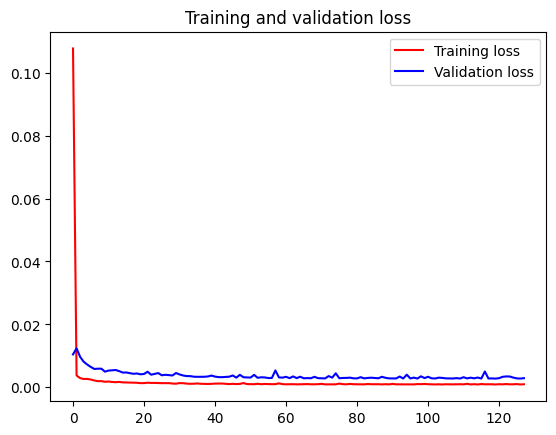

<Figure size 640x480 with 0 Axes>

In [37]:
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Lakukan prediksi dan periksa Performence metrics

In [38]:
train_predict_lstm=model_lstm.predict(X_train_lstm)
test_predict_lstm=model_lstm.predict(X_test_lstm)
train_predict_lstm.shape, test_predict_lstm.shape

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


((789, 1), (189, 1))

Ubah kembali ke bentuk Original (Denormalisasi)

In [39]:
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
original_ytrain_lstm = scaler.inverse_transform(y_train_lstm.reshape(-1,1))
original_ytest_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

## 2. CNN 1D

konversikan array nilai menjadi matriks kumpulan data kemudian tuning hyperparameter dan tampilkan history pelatihan modelnya, berlaku untuk 2 sel kebawah

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Create the dataset for CNN
def create_dataset_cnn(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset['Close'][i:(i + time_step)].values
        dataX.append(a)
        dataY.append(dataset['Close'].iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train_cnn, y_train_cnn = create_dataset_cnn(train_data_scaled, time_step)
X_test_cnn, y_test_cnn = create_dataset_cnn(test_data_scaled, time_step)

# Reshape the input data for CNN (samples, time steps, features)
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], X_test_cnn.shape[1], 1)

# Define the CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))  # Output layer for regression
model_cnn.compile(optimizer='adam', loss='mse')
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157 (51.39 KB)

 Trainable params: 13,157 (51.39 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=128, batch_size=32, validation_data=(X_test_cnn, y_test_cnn), verbose=1)

Epoch 1/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1700 - val_loss: 0.0195
Epoch 2/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0062 - val_loss: 0.0101
Epoch 3/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 0.0087
Epoch 4/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0084
Epoch 5/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0081
Epoch 6/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025 - val_loss: 0.0079
Epoch 7/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - val_loss: 0.0076
Epoch 8/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0074
Epoch 9/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0071
Epoch 10/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0069
Epoch 11/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0068
Epoch 12/128
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

Menampilkan Plotting Loss dan Validasi Loss

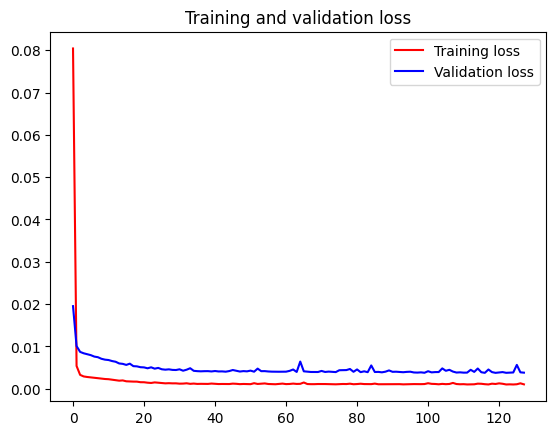

<Figure size 640x480 with 0 Axes>

In [42]:
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Melakukan prediksi dan periksa Performence metrics

In [43]:
train_predict_cnn=model_cnn.predict(X_train_cnn)
test_predict_cnn=model_cnn.predict(X_test_cnn)
train_predict_cnn.shape, test_predict_cnn.shape

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


((789, 1), (189, 1))

Ubah kembali ke bentuk Original (Denormalisasi)

In [44]:
train_predict_cnn = scaler.inverse_transform(train_predict_cnn)
test_predict_cnn = scaler.inverse_transform(test_predict_cnn)
original_ytrain_cnn = scaler.inverse_transform(y_train_cnn.reshape(-1,1))
original_ytest_cnn = scaler.inverse_transform(y_test_cnn.reshape(-1,1))

## 3. GRU

konversikan array nilai menjadi matriks kumpulan data kemudian tuning hyperparameter dan tampilkan history pelatihan modelnya

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Create the dataset for GRU
def create_dataset_gru(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset['Close'][i:(i + time_step)].values
        dataX.append(a)
        dataY.append(dataset['Close'].iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train_gru, y_train_gru = create_dataset_gru(train_data_scaled, time_step)
X_test_gru, y_test_gru = create_dataset_gru(test_data_scaled, time_step)

# Reshape the input data for GRU (samples, time steps, features)
X_train_gru = X_train_gru.reshape(X_train_gru.shape[0],X_train_gru.shape[1] , 1)
X_test_gru = X_test_gru.reshape(X_test_gru.shape[0],X_test_gru.shape[1] , 1)

# Define the GRU model
model_gru = Sequential()
model_gru.add(GRU(100, input_shape=(X_train_gru.shape[1], 1), activation='relu')) # Adjust units as needed
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

# Train the GRU model
history_gru = model_gru.fit(X_train_gru, y_train_gru, epochs=128, batch_size=16, validation_data=(X_test_gru,y_test_gru), verbose=1)

Epoch 1/128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1734 - val_loss: 0.0082
Epoch 2/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 3/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 4/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 5/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 6/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 7/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 8/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 9/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 10/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 0.0050
Epoch 11/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 12/128
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 

Menampilkan Plotting Loss and Validation Loss

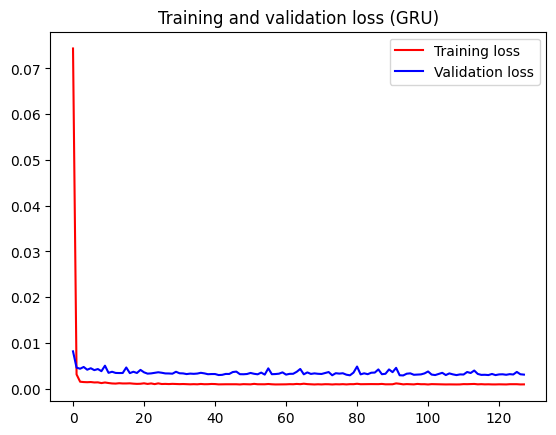

In [46]:
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (GRU)')
plt.legend()
plt.show()

Melakukan prediksi dan Denormalisasi

In [47]:
# Make predictions
train_predict_gru = model_gru.predict(X_train_gru)
test_predict_gru = model_gru.predict(X_test_gru)

# Inverse transform the predictions and actual values
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)
original_ytrain_gru = scaler.inverse_transform(y_train_lstm.reshape(-1,1)) # Use y_train_lstm here
original_ytest_gru = scaler.inverse_transform(y_test_lstm.reshape(-1,1)) # Use y_test_lstm here

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


# E. Evaluasi Model

## 1. Evaluasi Model LSTM

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error_lstm(y_true_lstm, y_pred_lstm):
    y_true_lstm, y_pred_lstm = np.array(y_true_lstm), np.array(y_pred_lstm)
    return np.mean(np.abs((y_true_lstm - y_pred_lstm) / y_true_lstm)) * 100

# Hitung Metrik Evaluasi untuk Data Training LSTM
mse_train_lstm = mean_squared_error(original_ytrain_lstm, train_predict_lstm)
rmse_train_lstm = np.sqrt(mse_train_lstm)
mae_train_lstm = mean_absolute_error(original_ytrain_lstm, train_predict_lstm)
mape_train_lstm = mean_absolute_percentage_error_lstm(original_ytrain_lstm, train_predict_lstm)
r2_train_lstm = r2_score(original_ytrain_lstm, train_predict_lstm)

# Hitung Metrik Evaluasi untuk Data Testing LSTM
mse_test_lstm = mean_squared_error(original_ytest_lstm, test_predict_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)
mae_test_lstm = mean_absolute_error(original_ytest_lstm, test_predict_lstm)
mape_test_lstm = mean_absolute_percentage_error_lstm(original_ytest_lstm, test_predict_lstm)
r2_test_lstm = r2_score(original_ytest_lstm, test_predict_lstm)

print("Training Data Metrics LSTM:")
print(f"MSE: {mse_train_lstm:.2f}")
print(f"RMSE: {rmse_train_lstm:.2f}")
print(f"MAE: {mae_train_lstm:.2f}")
print(f"MAPE: {mape_train_lstm:.2f}%")
print(f"R-squared: {r2_train_lstm:.2f}")

print("\nTesting Data Metrics LSTM:")
print(f"MSE: {mse_test_lstm:.2f}")
print(f"RMSE: {rmse_test_lstm:.2f}")
print(f"MAE: {mae_test_lstm:.2f}")
print(f"MAPE: {mape_test_lstm:.2f}%")
print(f"R-squared: {r2_test_lstm:.2f}")


Training Data Metrics LSTM:
MSE: 2645.47
RMSE: 51.43
MAE: 40.30
MAPE: 0.60%
R-squared: 0.98

Testing Data Metrics LSTM:
MSE: 8148.91
RMSE: 90.27
MAE: 67.61
MAPE: 0.97%
R-squared: 0.96


## 2. Evaluasi Model CNN 1D

In [49]:
def mean_absolute_percentage_error_cnn(y_true_cnn, y_pred_cnn):
    y_true_cnn, y_pred_cnn = np.array(y_true_cnn), np.array(y_pred_cnn)
    return np.mean(np.abs((y_true_cnn - y_pred_cnn) / y_true_cnn)) * 100

# Hitung metrik untuk data training CNN
mse_train_cnn = mean_squared_error(original_ytrain_cnn, train_predict_cnn)
rmse_train_cnn = np.sqrt(mse_train_cnn)
mae_train_cnn = mean_absolute_error(original_ytrain_cnn, train_predict_cnn)
mape_train_cnn = mean_absolute_percentage_error_cnn(original_ytrain_cnn, train_predict_cnn)
r2_train_cnn = r2_score(original_ytrain_cnn, train_predict_cnn)

# Hitung metrik untuk data testing CNN
mse_test_cnn = mean_squared_error(original_ytest_cnn, test_predict_cnn)
rmse_test_cnn = np.sqrt(mse_test_cnn)
mae_test_cnn = mean_absolute_error(original_ytest_cnn, test_predict_cnn)
mape_test_cnn = mean_absolute_percentage_error_cnn(original_ytest_cnn, test_predict_cnn)
r2_test_cnn = r2_score(original_ytest_cnn, test_predict_cnn)

print("\nTraining Data Metrics CNN:")
print(f"MSE: {mse_train_cnn:.4f}")
print(f"RMSE: {rmse_train_cnn:.4f}")
print(f"MAE: {mae_train_cnn:.4f}")
print(f"MAPE: {mape_train_cnn:.2f}%")
print(f"R-squared: {r2_train_cnn:.4f}")

print("\nTesting Data Metrics CNN:")
print(f"MSE: {mse_test_cnn:.4f}")
print(f"RMSE: {rmse_test_cnn:.4f}")
print(f"MAE: {mae_test_cnn:.4f}")
print(f"MAPE: {mape_test_cnn:.2f}%")
print(f"R-squared: {r2_test_cnn:.4f}")


Training Data Metrics CNN:
MSE: 2959.4760
RMSE: 54.4011
MAE: 40.7370
MAPE: 0.60%
R-squared: 0.9803

Testing Data Metrics CNN:
MSE: 10586.3916
RMSE: 102.8902
MAE: 76.0169
MAPE: 1.09%
R-squared: 0.9442


## 3. Evaluasi Model GRU

In [50]:
def mean_absolute_percentage_error_gru(y_true_gru, y_pred_gru):
    y_true_gru, y_pred_gru = np.array(y_true_gru), np.array(y_pred_gru)
    return np.mean(np.abs((y_true_gru - y_pred_gru) / y_true_gru)) * 100

# Hitung Metrik Evaluasi untuk Data Training GRU
mse_train_gru = mean_squared_error(original_ytrain_gru, train_predict_gru)
rmse_train_gru = np.sqrt(mse_train_gru)
mae_train_gru = mean_absolute_error(original_ytrain_gru, train_predict_gru)
mape_train_gru = mean_absolute_percentage_error_gru(original_ytrain_gru, train_predict_gru)
r2_train_gru = r2_score(original_ytrain_gru, train_predict_gru)

# Hitung Metrik Evaluasi untuk Data Testing GRU
mse_test_gru = mean_squared_error(original_ytest_gru, test_predict_gru)
rmse_test_gru = np.sqrt(mse_test_gru)
mae_test_gru = mean_absolute_error(original_ytest_gru, test_predict_gru)
mape_test_gru = mean_absolute_percentage_error_gru(original_ytest_gru, test_predict_gru)
r2_test_gru = r2_score(original_ytest_gru, test_predict_gru)

print("\nTraining Data Metrics GRU:")
print(f"MSE: {mse_train_gru:.2f}")
print(f"RMSE: {rmse_train_gru:.2f}")
print(f"MAE: {mae_train_gru:.2f}")
print(f"MAPE: {mape_train_gru:.2f}%")
print(f"R-squared: {r2_train_gru:.2f}")

print("\nTesting Data Metrics GRU:")
print(f"MSE: {mse_test_gru:.2f}")
print(f"RMSE: {rmse_test_gru:.2f}")
print(f"MAE: {mae_test_gru:.2f}")
print(f"MAPE: {mape_test_gru:.2f}%")
print(f"R-squared: {r2_test_gru:.2f}")


Training Data Metrics GRU:
MSE: 3057.25
RMSE: 55.29
MAE: 42.15
MAPE: 0.63%
R-squared: 0.98

Testing Data Metrics GRU:
MSE: 8593.44
RMSE: 92.70
MAE: 67.56
MAPE: 0.97%
R-squared: 0.95


## 4. Kesimpulan

In [51]:
# membuat kamus berdasarkan hasil
results = {
    'Model': ['LSTM', 'CNN', 'GRU'],
    'MSE_Train': [mse_train_lstm, mse_train_cnn, mse_train_gru],
    'RMSE_Train': [rmse_train_lstm, rmse_train_cnn, rmse_train_gru],
    'MAE_Train': [mae_train_lstm, mae_train_cnn, mae_train_gru],
    'MAPE_Train': [mape_train_lstm, mape_train_cnn, mape_train_gru],
    'R2_Train': [r2_train_lstm, r2_train_cnn, r2_train_gru],
    'MSE_Test': [mse_test_lstm, mse_test_cnn, mse_test_gru],
    'RMSE_Test': [rmse_test_lstm, rmse_test_cnn, rmse_test_gru],
    'MAE_Test': [mae_test_lstm, mae_test_cnn, mae_test_gru],
    'MAPE_Test': [mape_test_lstm, mape_test_cnn, mape_test_gru],
    'R2_Test': [r2_test_lstm, r2_test_cnn, r2_test_gru],
}

# Membuat dataframe berasarkan result(hasil)
df_results = pd.DataFrame(results)
print(df_results)

# Sortir berdasarkan R2
df_results_sorted = df_results.sort_values(by=['MSE_Test', 'R2_Test'], ascending=[True, True])
print("\nModel terbaik berdasarkan Evaluasi:")
df_results_sorted

  Model    MSE_Train  RMSE_Train  MAE_Train  MAPE_Train  R2_Train  \
0  LSTM  2645.470245   51.434135  40.298577    0.595780  0.982369   
1   CNN  2959.475973   54.401066  40.737010    0.604134  0.980277   
2   GRU  3057.249324   55.292398  42.152232    0.625995  0.979625   

       MSE_Test   RMSE_Test   MAE_Test  MAPE_Test   R2_Test  
0   8148.909553   90.271311  67.606890   0.967162  0.957032  
1  10586.391559  102.890192  76.016937   1.090479  0.944180  
2   8593.443377   92.700827  67.563518   0.970458  0.954688  

Model terbaik berdasarkan Evaluasi:


,Model,MSE_Train,RMSE_Train,MAE_Train,MAPE_Train,R2_Train,MSE_Test,RMSE_Test,MAE_Test,MAPE_Test,R2_Test
0,LSTM,2645.470245,51.434135,40.298577,0.595780,0.982369,8148.909553,90.271311,67.606890,0.967162,0.957032
2,GRU,3057.249324,55.292398,42.152232,0.625995,0.979625,8593.443377,92.700827,67.563518,0.970458,0.954688
1,CNN,2959.475973,54.401066,40.737010,0.604134,0.980277,10586.391559,102.890192,76.016937,1.090479,0.944180


**Berdasarkan Hasil Evaluasi Model, LSTM merupakan Model Terbaik untuk studi kasus Time Series univariate**

Maka dari itu Model **LSTM** yang akan dipilih untuk dijadikan implementasi.

# F. Implementasi

Simpan Model:

In [52]:
import tensorflow as tf

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm) # Change to model_lstm

# Enable resource variables (if needed)
converter.experimental_enable_resource_variables = True

# Set supported ops to include Select TF ops (if needed)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('lstm_model.tflite', 'wb') as f:  # Change filename
    f.write(tflite_model)

Saved artifact at '/tmp/tmp_9v9bdra'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135670443538192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135670443540304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135670443536464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135670443539728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135670443538000: TensorSpec(shape=(), dtype=tf.resource, name=None)


Data Sebelum dan Sesudah Prediksi:

In [53]:
import plotly.express as px
from itertools import cycle

look_back = time_step

train_predict_plot = np.empty_like(maindf_cleaned_split[['Close']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict_lstm) + look_back, :] = train_predict_lstm
print("Train predicted data: ", train_predict_plot.shape)

test_predict_plot = np.empty_like(maindf_cleaned_split[['Close']])
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_lstm) + (look_back * 2) + 1:len(maindf_cleaned_split[['Close']]) - 1, :] = test_predict_lstm
print("Test predicted data: ", test_predict_plot.shape)

plotdf = pd.DataFrame({'Date': maindf_cleaned_split.index,
                       'original_close': maindf_cleaned_split['Close'],
                       'train_predicted_close': train_predict_plot.reshape(1, -1)[0].tolist(),
                       'test_predicted_close': test_predict_plot.reshape(1, -1)[0].tolist()})


names = cycle(['Data Harga Asli', 'Data Harga(berdsasarkan data latih)', 'Data Harga(berdsasarkan data Uji)'])

fig = px.line(plotdf, x=plotdf['Date'], y=[plotdf['original_close'], plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value': 'Harga IHSG(^JKSE)', 'Date': 'Tanggal'})
fig.update_layout(title_text='Komparasi dari Harga Penutupan asli dengan Harga Penutupan Hasil Prediksi',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(name=next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1000, 1)
Test predicted data:  (1000, 1)


Contoh penggunaan untuk prediksi 7 hari kedepan:

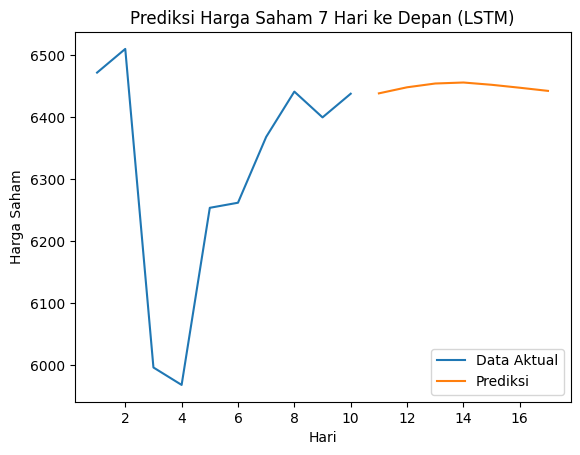

In [54]:
# Predict the next 7 days using LSTM
x_input = test_data_scaled[-10:].values  # Taking the last 10 days' data
x_input = x_input.reshape(1, -1, 1)  # Reshaping for LSTM input

temp_input = list(x_input[0].flatten())
lst_output = []
n_steps = 10

i = 0
while i < 7:
    if len(temp_input) > 10:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        yhat = model_lstm.predict(x_input, verbose=0)  # Using model_lstm for prediction
        temp_input.extend(yhat[0].flatten().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model_lstm.predict(x_input, verbose=0)  # Using model_lstm for prediction
        temp_input.extend(yhat[0].flatten().tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

day_new = np.arange(1, 11)
day_pred = np.arange(11, 18)

plt.plot(day_new, scaler.inverse_transform(test_data_scaled[-10:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
plt.title('Prediksi Harga Saham 7 Hari ke Depan (LSTM)')  # Updated title
plt.xlabel('Hari')
plt.ylabel('Harga Saham')
plt.legend(['Data Aktual', 'Prediksi'])
plt.show()

In [55]:
!pip freeze > requirements.txt